In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
import ubelt as ub
import pint
site.addsitedir('../../../ARGUS')
from ARGUS_Transforms import ARGUS_RandSpatialCropSlicesd  #NOQA
Ureg = pint.UnitRegistry()

In [2]:
img1_dir = "../../Data_ONSD/Preprocessed/"
img2_dir = "../../Data_ONSD/Annotations/CLEANED/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_cropM.mha')))
all_labels = sorted(glob(os.path.join(img2_dir, '*.overlay.mha')))

num_devices = 1
gpu_device = 3
runs = 3

num_classes = 3

net_in_dims = 3 # Spatial Dimensions
net_in_channels = 1
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)
        
num_folds = 8

num_slice = 16
size_x = 320
size_y = 640

num_workers_tr = 4
batch_size_tr = 8
num_workers_te = 2
batch_size_te = 2

In [3]:
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

p_prefix = [
        ' 158',
        ' 64',
        ' 139',
        ' 87',
        ' 117',
        ' 130',
        ' 205',
        ' 209',
        ' 213'
    ]
n_prefix = [
        ' 23',
        ' 108',
        ' 119',
        ' 129',
        ' 163',
        ' 191',
        ' 228',
        ' 250'
    ]


fold_prefix_list = []
p_count = 0
n_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_p = 1
        num_n = 1
        if i > num_folds-2:
            num_p = 2
    else:
        num_p = 1
        num_n = 1
    f = []
    if p_count < len(p_prefix):
        for p in range(num_p):
            f.append([p_prefix[p_count+p]])
    p_count += num_p
    if n_count < len(n_prefix):
        for n in range(num_n):
            f.append([n_prefix[n_count+n]])
    n_count += num_n
    fold_prefix_list.append(f)

for i in range(num_folds):
    print(i, fold_prefix_list[i])

Num images / labels = 19 19
0 [[' 158'], [' 23']]
1 [[' 64'], [' 108']]
2 [[' 139'], [' 119']]
3 [[' 87'], [' 129']]
4 [[' 117'], [' 163']]
5 [[' 130'], [' 191']]
6 [[' 205'], [' 228']]
7 [[' 209'], [' 250']]


In [4]:
total_bytes = 0
for p in all_images:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

total_bytes = 0
for p in all_labels:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

0.831169568002224 gibibyte
0.004821689799427986 gibibyte


In [5]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    va_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    for f in range(i+num_folds-2, i+num_folds-1):
        va_folds.append(fold_prefix_list[f%num_folds])
    va_folds = list(np.concatenate(va_folds).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

13 2 3
12 3 3
13 3 2
14 2 2
14 2 2
14 2 2
14 2 2
14 2 2


In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slice,
            axis=3,
            require_labeled=True,
            reduce_to_statistics=[False,False],
            extended=False,
            include_center_slice=False,
            include_mean_abs_diff=False,
            keys=['image','label']),
        Resized(
            spatial_size=(-1,size_y,-1),
            mode=["trilinear","nearest"],
            keys=['image','label']
        ),
        RandSpatialCropd(
            roi_size=(size_x,size_y,-1),
            random_center=True,
            random_size=False,
            keys=['image','label']
        ),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slice,
            center_slice=-num_slice/2 - 1,
            axis=3,
            require_labeled=True,
            reduce_to_statistics=[False,False],
            extended=False,
            include_center_slice=False,
            include_mean_abs_diff=False,
            keys=['image','label']),
        Resized(
            spatial_size=(-1,size_y,-1),
            mode=["trilinear","nearest"],
            keys=['image','label'],
        ),
        ToTensord(keys=["image", "label"])
    ]
)

In [7]:
device = torch.device("cpu")

In [10]:
model_type = "best"  #"best" or "last"

def plot_vfold_training_curves(vfold_num, test_loader):
    print("VFOLD =", vfold_num, "of", num_folds - 1)

    for run in range(0,runs):
        experiment_type = '3D'
        model_filename_base = "./results/BAMC_ONSD-CLEANED_ARUNet-" + str(experiment_type) + "-yuriNerveData-" + str(num_slice) + "s-VFold-Run" + str(run)
        model_filename_base = model_filename_base+"/"
        model_file = model_filename_base+model_type+'_model.vfold_'+str(vfold_num)+'.pth'
        if os.path.exists(model_file):
            model = UNet(
                dimensions=net_in_dims,
                in_channels=net_in_channels,
                out_channels=num_classes,
                channels=net_channels,
                strides=net_strides,
                num_res_units=2,
                norm=Norm.BATCH,
        ).to(device)
            dice_metric = DiceMetric(include_background=False, reduction="mean")
            post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
            post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])   
            model.load_state_dict(torch.load(model_file))
            model.eval()

            with torch.no_grad():
                i = 0
                for b,test_data in enumerate(test_loader):
                    print(b)
                    print(test_data["image"].shape)
                    roi_size = (size_x, size_y,num_slice)
                    sw_batch_size = 1
                    test_outputs = sliding_window_inference(
                        test_data["image"].to(device), roi_size, sw_batch_size, model
                    )
                    test_labels = test_data["label"].to(device)
                    test_outputs_list = [post_pred(i) for i in decollate_batch(test_outputs)]
                    test_labels_list = [post_label(i) for i in decollate_batch(test_labels)]
                    dice_metric(y_pred=test_outputs_list, y=test_labels_list)
                    metric = dice_metric.aggregate().item()
                    print("Average test dice score for Vfold " + str(vfold_num) + " = " +str(metric))
                    dice_metric.reset()
                    if b > 0:
                        test_outputs_total = np.concatenate((test_outputs_total,test_outputs),axis=0)
                        test_images_total = np.concatenate((test_images_total,test_data["image"].to(device)),axis=0)
                        test_labels_total = np.concatenate((test_labels_total,test_data["label"].to(device)),axis=0)
                        i += 1
                    else:
                        test_outputs_total = test_outputs
                        test_images_total = test_data["image"].to(device)
                        test_labels_total = test_data["label"].to(device)

    nerve_prior = 1
    class_nerve = 1

    min_size = 60000
    max_size = 100000
    
    print("Output shape: " + str(test_outputs_total.shape))
    print("Images shape: " + str(test_images_total.shape))
    print("Labels shape: " + str(test_labels_total.shape))
    test_op = test_outputs_total[:,[0,2],:,:,:]
    print("Test_op shape: " + str(test_op.shape))

    for x in range(0,len(train_files[vfold_num])):
        print(train_files[vfold_num][x]["image"])
    for j in range(test_outputs_total.shape[0]):
        print("J = " + str(j))
        print("Filename: ")
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image")
        tmpV = test_images_total[j,0,:,:,7]
        plt.imshow(tmpV, cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label")
        tmpV = test_labels_total[j,0,:,:,7]
        tmpV[0,0]=0
        tmpV[0,1]=1
        plt.imshow(tmpV)
        plt.subplot(1, 3, 3)
        plt.title(f"output")
        prob_shape = test_outputs_total[j,[0,2],:,:,:].shape
        prob = np.empty(prob_shape)
        prob_total = 0
        for run in range(0,runs):
            for c in range(num_classes - 1):
                itkProb = itk.GetImageFromArray(test_op[j,c,:,:,:])
                imMathProb = ttk.ImageMath.New(itkProb)
                imMathProb.Blur(5)
                itkProb = imMathProb.GetOutput()
                prob[c] = itk.GetArrayFromImage(itkProb)
            class_array = np.zeros(prob[0].shape)
            pmin = prob[0].min()
            pmax = prob[0].max()
            for c in range(1,num_classes - 1):
                pmin = min(pmin, prob[c].min())
                pmax = max(pmax, prob[c].max())
            prange = pmax - pmin
            prob = (prob - pmin) / prange
            prob[class_nerve] = prob[class_nerve] * nerve_prior
            done = False
            while not done:
                done = True
                count = np.count_nonzero(class_array>0)
                while count<min_size:
                    prob[class_nerve] = prob[class_nerve] * 1.05
                    class_array = np.argmax(prob,axis=0)
                    count = np.count_nonzero(class_array>0)
                    done = False
                while count>max_size:
                    prob[class_nerve] = prob[class_nerve] * 0.95
                    class_array = np.argmax(prob,axis=0)
                    count = np.count_nonzero(class_array>0)
                    done = False
            denom = (prob[class_nerve] + prob[0])
            denom = np.where(denom==0,1,denom)
            prob_total += (prob[class_nerve]/denom)
            
        prob_total = prob_total / runs
        class_array = np.where(prob_total>0.5,1,0)
        class_image = itk.GetImageFromArray(class_array.astype(np.float32))
        imMathClassCleanup = ttk.ImageMath.New(class_image)
        imMathClassCleanup.Erode(5,class_nerve,0)
        imMathClassCleanup.Dilate(5,class_nerve,0)
        class_output = imMathClassCleanup.GetOutputUChar()
        
        seg = itk.itkARGUS.SegmentConnectedComponents.New(Input=class_output)
        seg.SetKeepOnlyLargestComponent(True)
        seg.Update()

        class_output = seg.GetOutput()
        class_output_array = itk.GetArrayFromImage(class_output)
        test_label = test_labels_total[j,0,:,:,:]
        class_label = test_label
        tmpV[0,0]=0
        tmpV[0,1]=1
        class_output_array[0,0]=0
        class_output_array[0,1]=1
        plt.imshow(class_output_array[:,:,7])
        plt.show()


Loading dataset: 100%|██████████| 13/13 [00:14<00:00,  1.10s/it]

VFOLD = 0 of 7



`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 0 = 0.3794950246810913
1
torch.Size([5, 1, 320, 640, 16])
Average test dice score for Vfold 0 = 0.30630481243133545


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 0 = 0.45677152276039124
1
torch.Size([5, 1, 320, 640, 16])
Average test dice score for Vfold 0 = 0.46251872181892395


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 0 = 0.4361271262168884
1
torch.Size([5, 1, 320, 640, 16])
Average test dice score for Vfold 0 = 0.42038822174072266
Output shape: (13, 3, 320, 640, 16)
Images shape: (13, 1, 320, 640, 16)
Labels shape: (13, 1, 320, 640, 16)
Test_op shape: (13, 2, 320, 640, 16)
../../Data_ONSD/Preprocessed/2. 119.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 158.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 163.2 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 64.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 139.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 191.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 23.1 Right_Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 87.2 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 117.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 129.1 Left_Lat_Video 1_cropM.mha
../../Data_

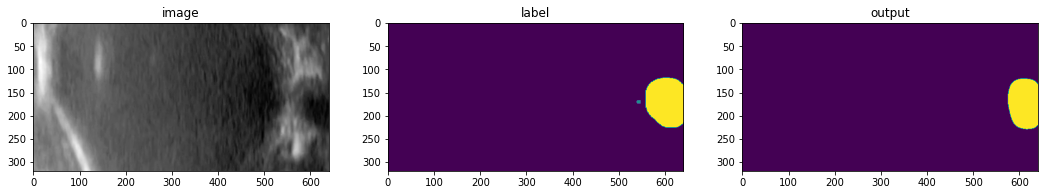

J = 1
Filename: 


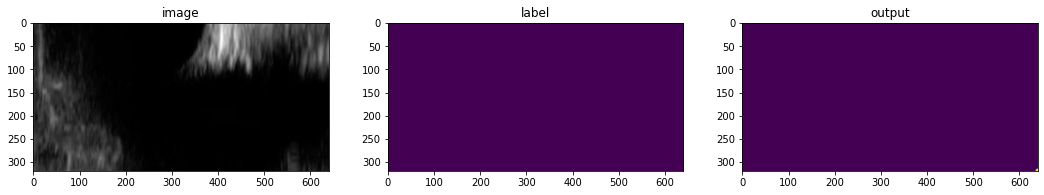

J = 2
Filename: 


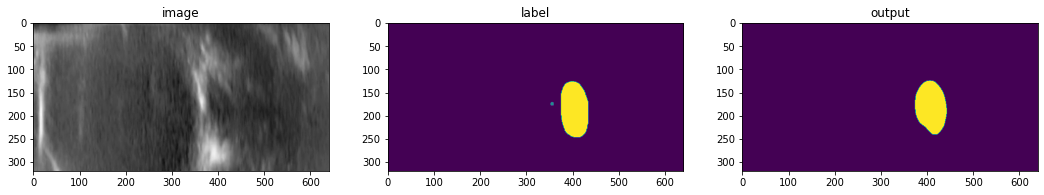

J = 3
Filename: 


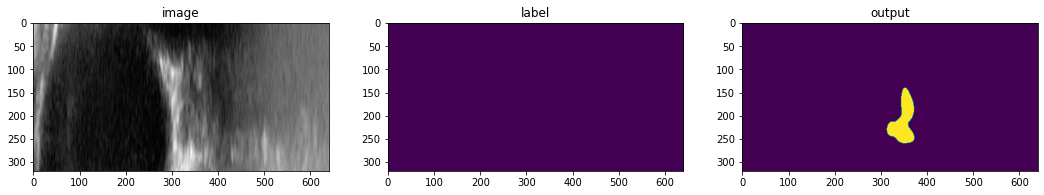

J = 4
Filename: 


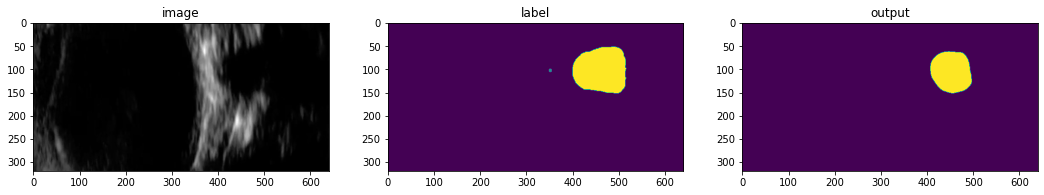

J = 5
Filename: 


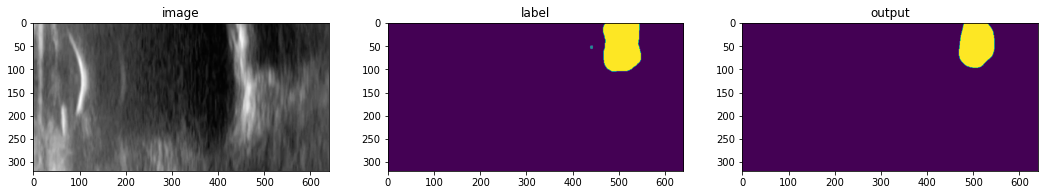

J = 6
Filename: 


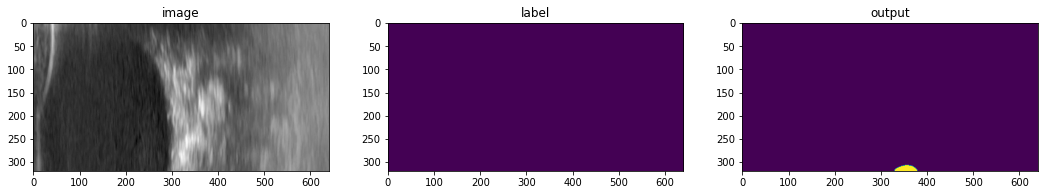

J = 7
Filename: 


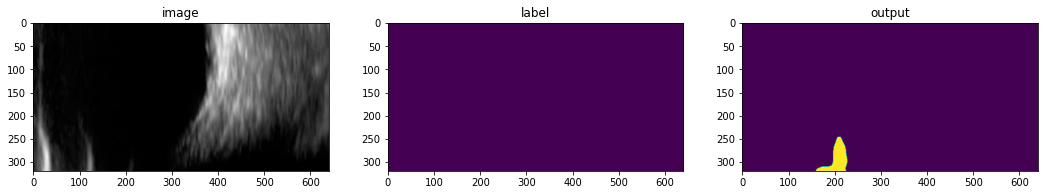

J = 8
Filename: 


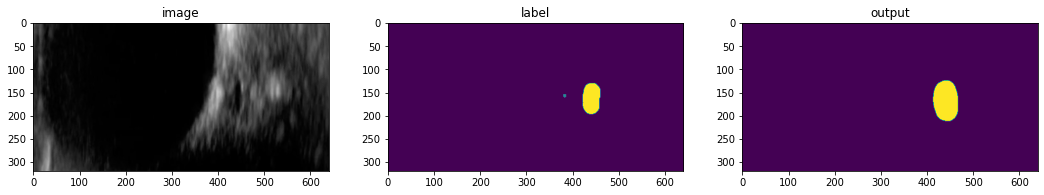

J = 9
Filename: 


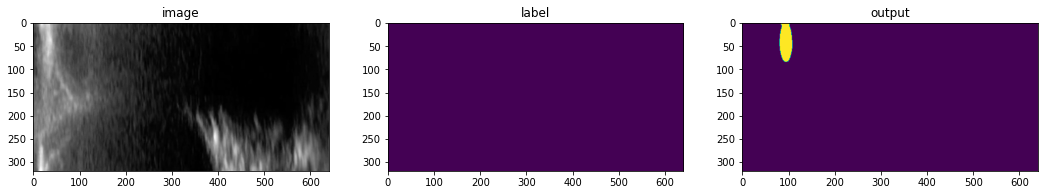

J = 10
Filename: 


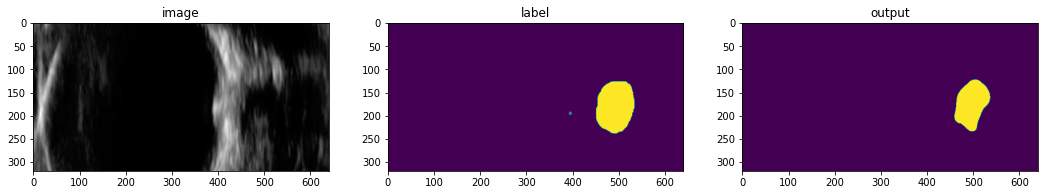

J = 11
Filename: 


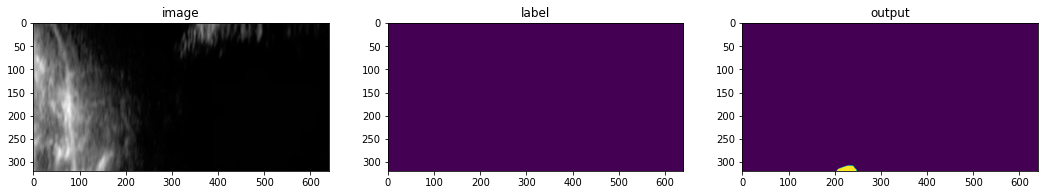

J = 12
Filename: 


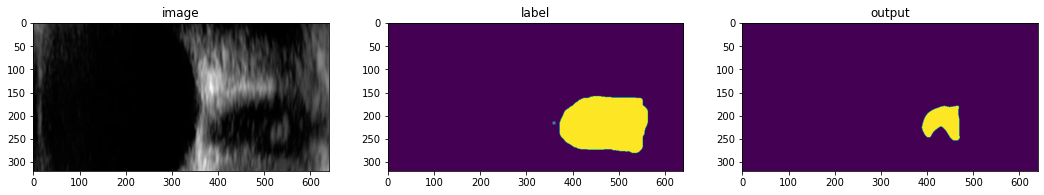

Loading dataset: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]

VFOLD = 1 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 1 = 0.39383336901664734
1
torch.Size([4, 1, 320, 640, 16])
Average test dice score for Vfold 1 = 0.44721508026123047


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 1 = 0.46429529786109924
1
torch.Size([4, 1, 320, 640, 16])
Average test dice score for Vfold 1 = 0.4631510078907013


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 1 = 0.35581454634666443
1
torch.Size([4, 1, 320, 640, 16])
Average test dice score for Vfold 1 = 0.42660242319107056
Output shape: (12, 3, 320, 640, 16)
Images shape: (12, 1, 320, 640, 16)
Labels shape: (12, 1, 320, 640, 16)
Test_op shape: (12, 2, 320, 640, 16)
../../Data_ONSD/Preprocessed/2. 119.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 163.2 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 228.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 64.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 139.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 191.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 87.2 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 117.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 129.1 Left_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/7. 108.1 Left_Lat_Video 1_cropM.mha
../../Data_

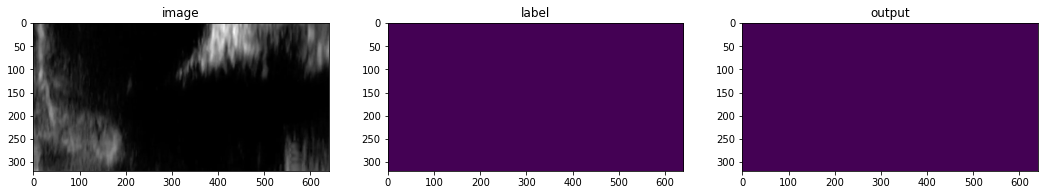

J = 1
Filename: 


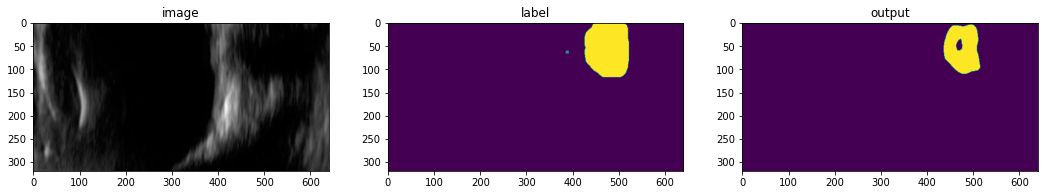

J = 2
Filename: 


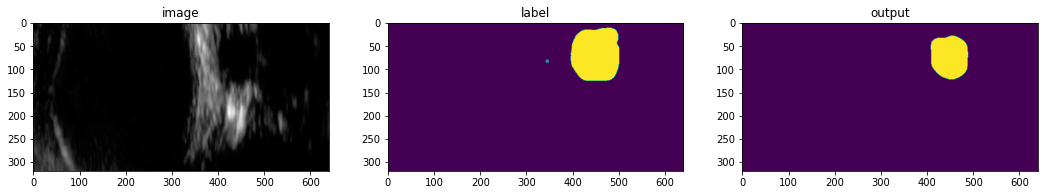

J = 3
Filename: 


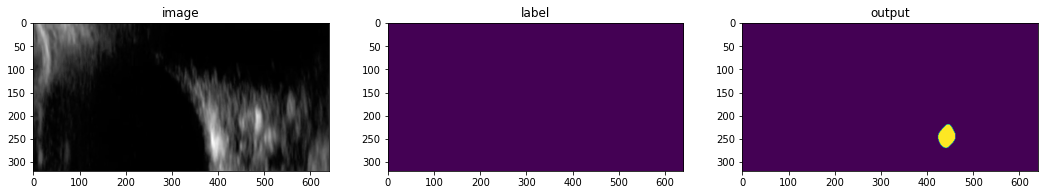

J = 4
Filename: 


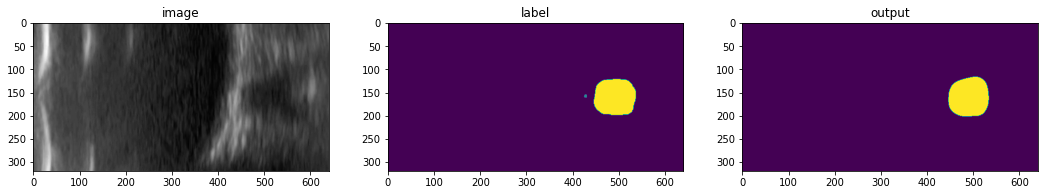

J = 5
Filename: 


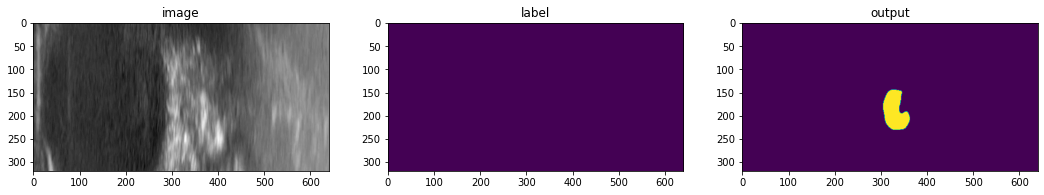

J = 6
Filename: 


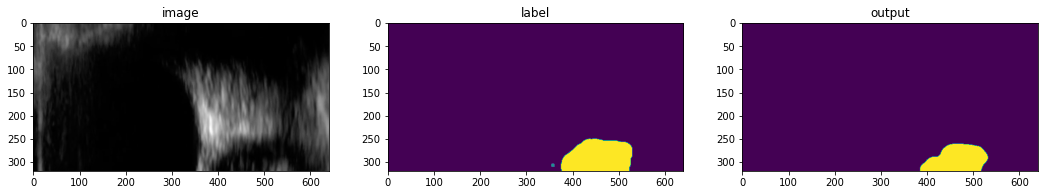

J = 7
Filename: 


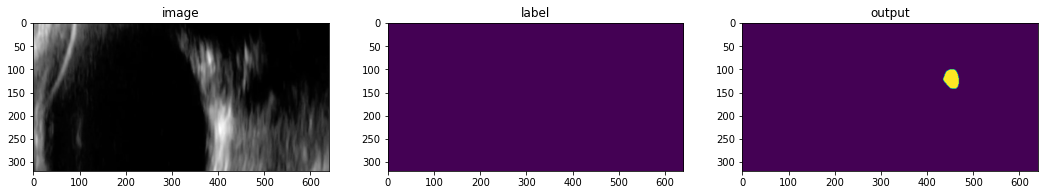

J = 8
Filename: 


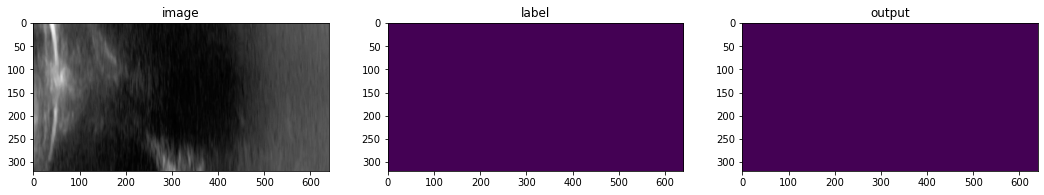

J = 9
Filename: 


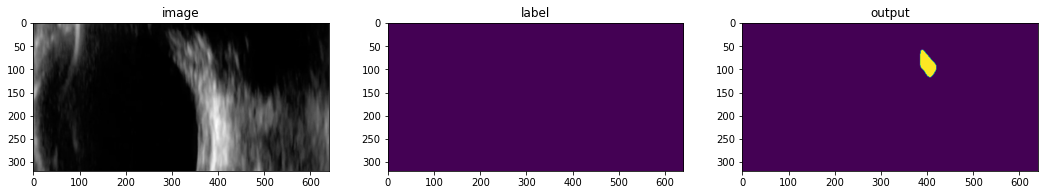

J = 10
Filename: 


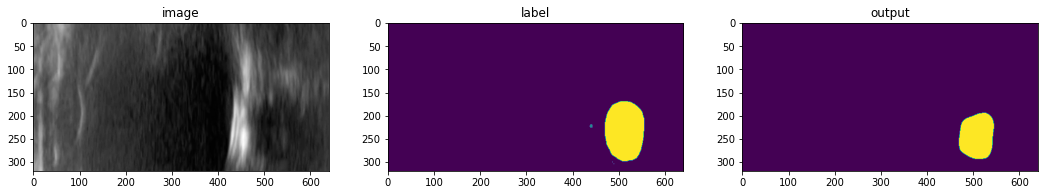

J = 11
Filename: 


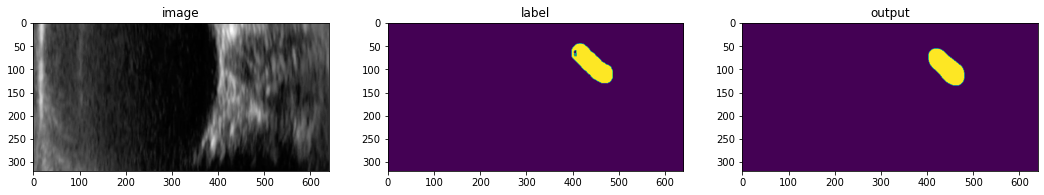

Loading dataset: 100%|██████████| 13/13 [00:13<00:00,  1.02s/it]

VFOLD = 2 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 2 = 0.41276487708091736
1
torch.Size([5, 1, 320, 640, 16])
Average test dice score for Vfold 2 = 0.4137588441371918


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 2 = 0.3731233775615692
1
torch.Size([5, 1, 320, 640, 16])
Average test dice score for Vfold 2 = 0.35816723108291626


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 2 = 0.43814247846603394
1
torch.Size([5, 1, 320, 640, 16])
Average test dice score for Vfold 2 = 0.5979297757148743
Output shape: (13, 3, 320, 640, 16)
Images shape: (13, 1, 320, 640, 16)
Labels shape: (13, 1, 320, 640, 16)
Test_op shape: (13, 2, 320, 640, 16)
../../Data_ONSD/Preprocessed/10. 250.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 119.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 163.2 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 228.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/3. 250.1 Right Lat_Video 2_cropM.mha
../../Data_ONSD/Preprocessed/4. 139.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 191.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 87.2 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 117.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 129.1 Left_Lat_Video 1_cropM.mha
../../Data

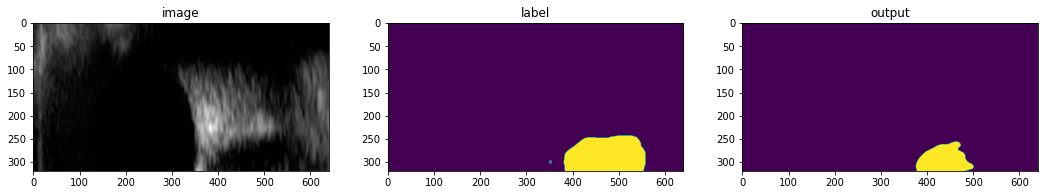

J = 1
Filename: 


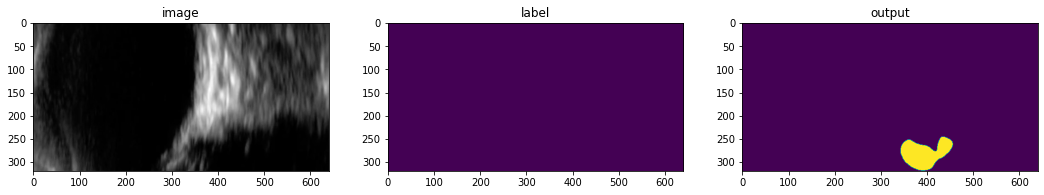

J = 2
Filename: 


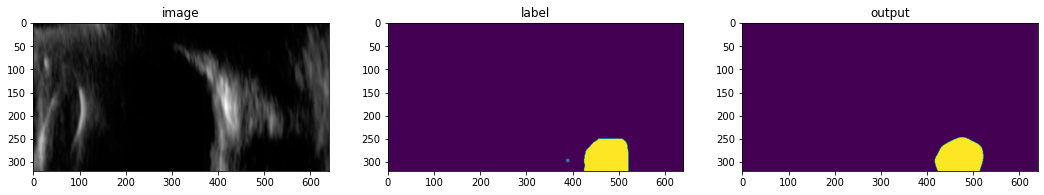

J = 3
Filename: 


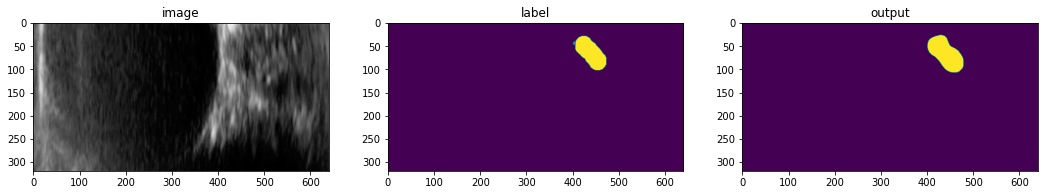

J = 4
Filename: 


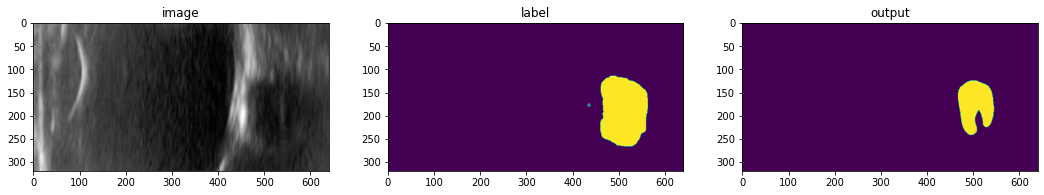

J = 5
Filename: 


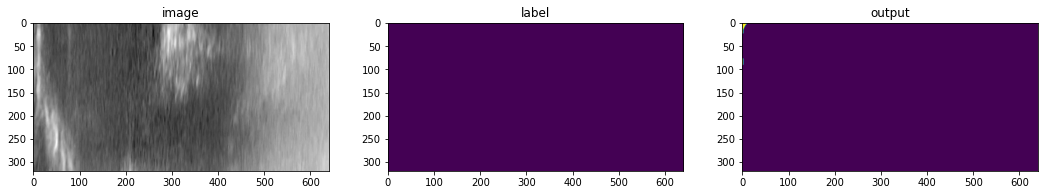

J = 6
Filename: 


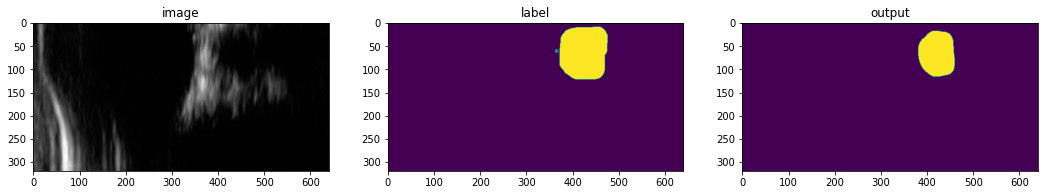

J = 7
Filename: 


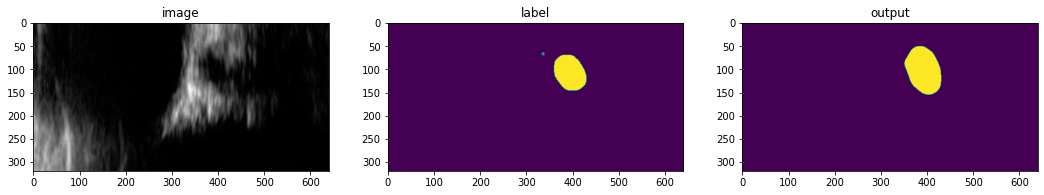

J = 8
Filename: 


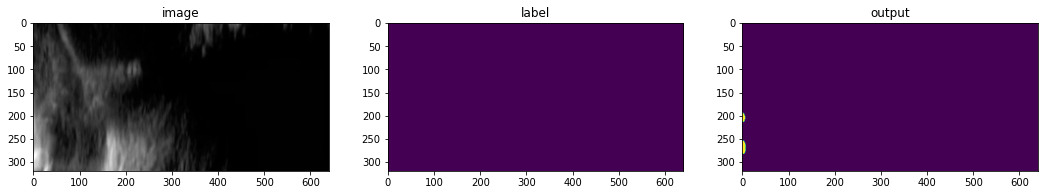

J = 9
Filename: 


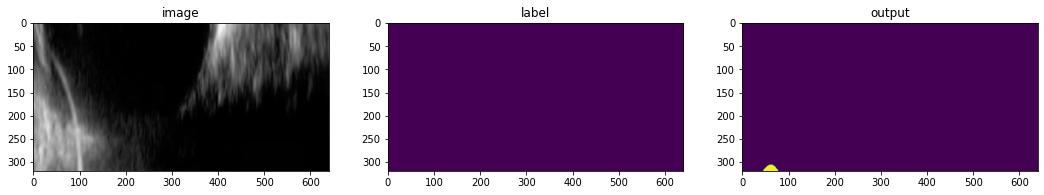

J = 10
Filename: 


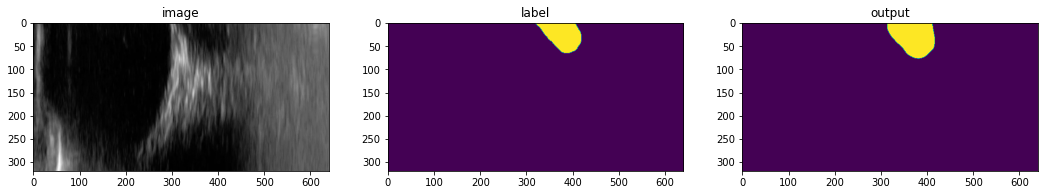

J = 11
Filename: 


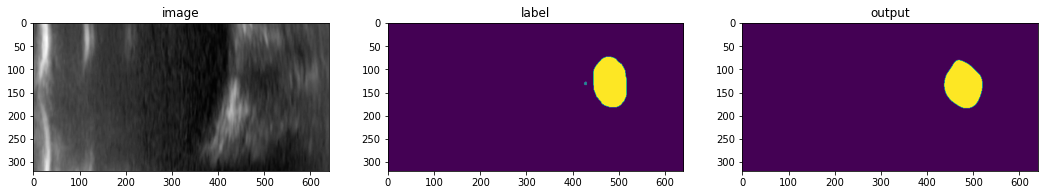

J = 12
Filename: 


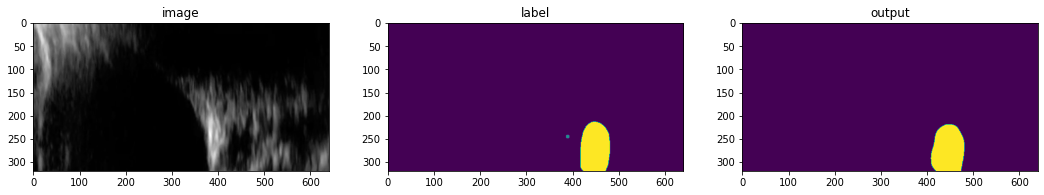

Loading dataset: 100%|██████████| 14/14 [00:13<00:00,  1.01it/s]

VFOLD = 3 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 3 = 0.4435949921607971
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 3 = 0.35795164108276367


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 3 = 0.5416940450668335
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 3 = 0.5644376873970032


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 3 = 0.4318968653678894
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 3 = 0.46863609552383423
Output shape: (14, 3, 320, 640, 16)
Images shape: (14, 1, 320, 640, 16)
Labels shape: (14, 1, 320, 640, 16)
Test_op shape: (14, 2, 320, 640, 16)
../../Data_ONSD/Preprocessed/10. 250.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 158.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 163.2 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 228.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/3. 250.1 Right Lat_Video 2_cropM.mha
../../Data_ONSD/Preprocessed/4. 191.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 23.1 Right_Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 87.2 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 117.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 129.1 Left_Lat_Video 1_cropM.mha
../../Data_

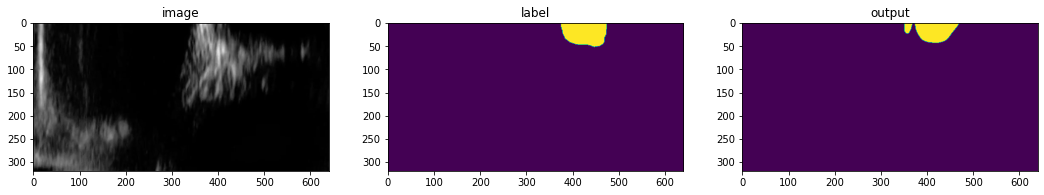

J = 1
Filename: 


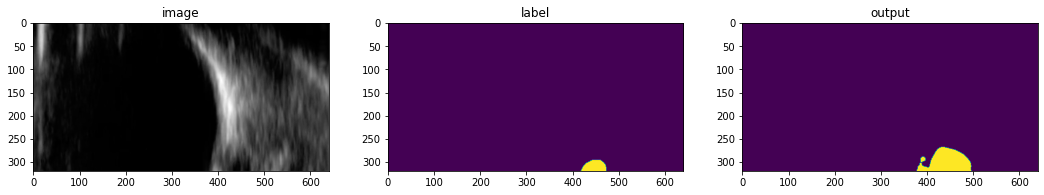

J = 2
Filename: 


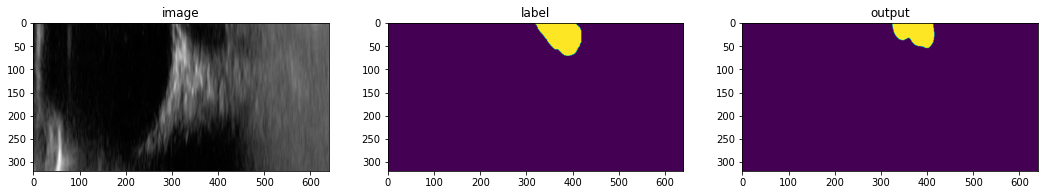

J = 3
Filename: 


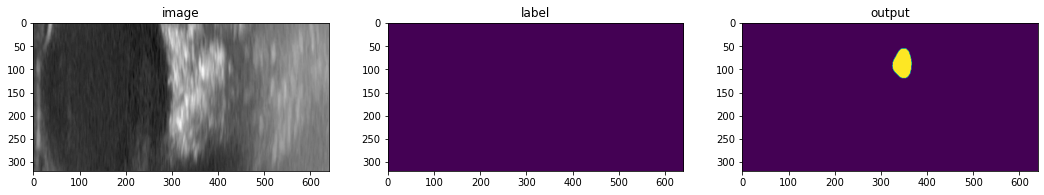

J = 4
Filename: 


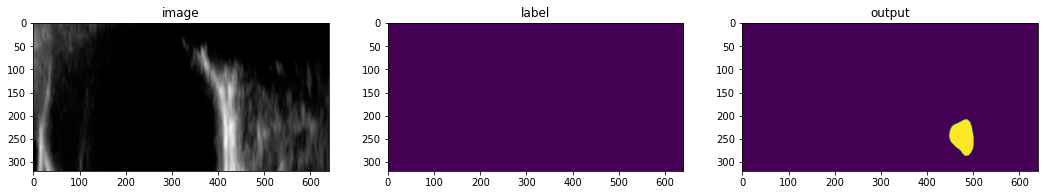

J = 5
Filename: 


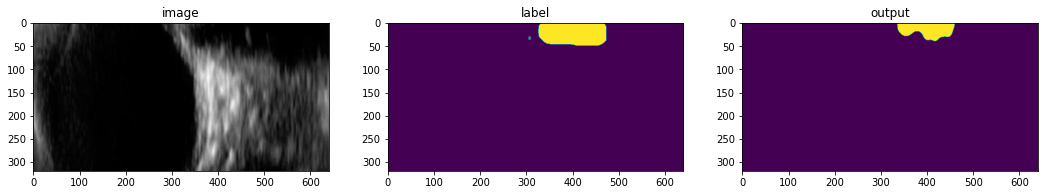

J = 6
Filename: 


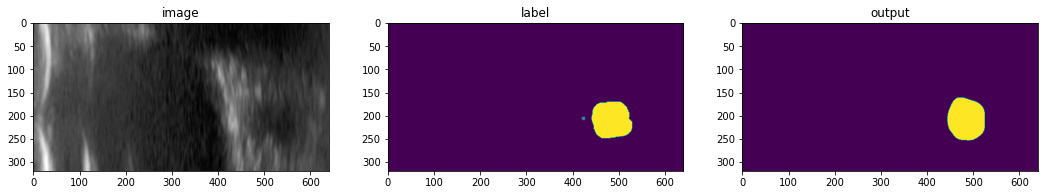

J = 7
Filename: 


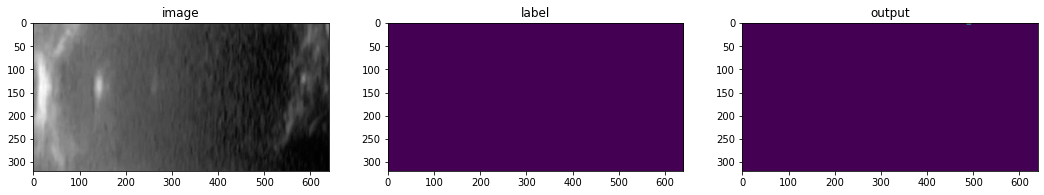

J = 8
Filename: 


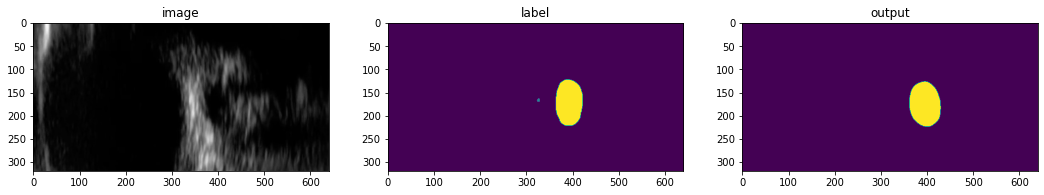

J = 9
Filename: 


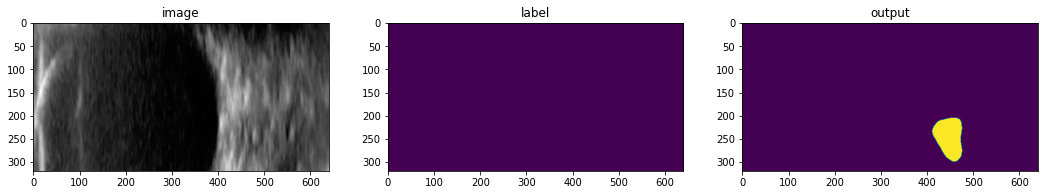

J = 10
Filename: 


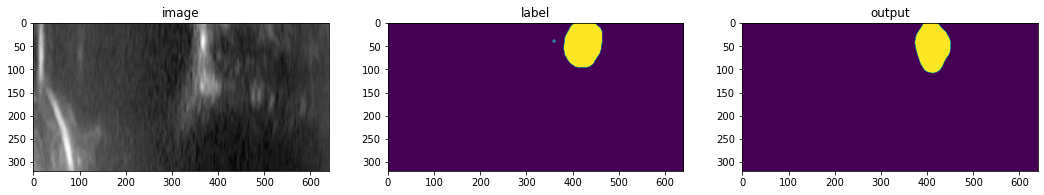

J = 11
Filename: 


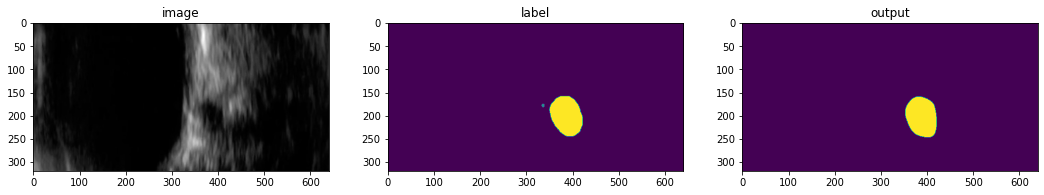

J = 12
Filename: 


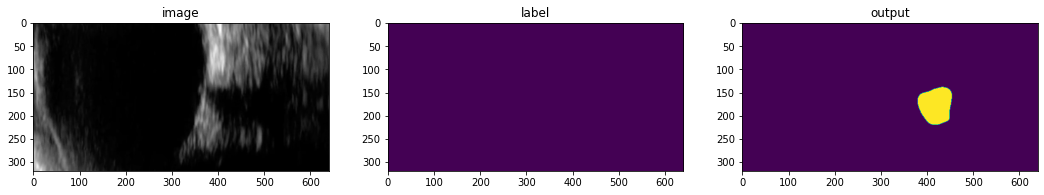

J = 13
Filename: 


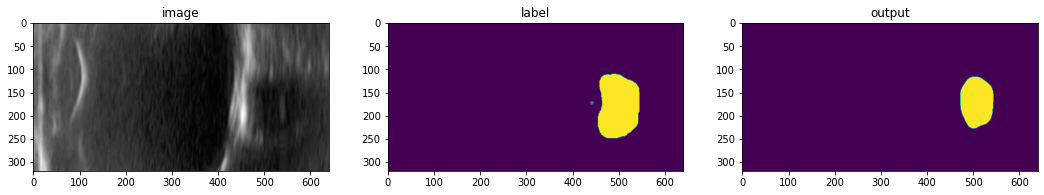

Loading dataset: 100%|██████████| 14/14 [00:14<00:00,  1.02s/it]

VFOLD = 4 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 4 = 0.4408823549747467
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 4 = 0.6333066821098328


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 4 = 0.5430682301521301
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 4 = 0.43027278780937195


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 4 = 0.44627445936203003
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 4 = 0.36818835139274597
Output shape: (14, 3, 320, 640, 16)
Images shape: (14, 1, 320, 640, 16)
Labels shape: (14, 1, 320, 640, 16)
Test_op shape: (14, 2, 320, 640, 16)
../../Data_ONSD/Preprocessed/10. 250.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 158.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 163.2 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 228.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 64.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/3. 250.1 Right Lat_Video 2_cropM.mha
../../Data_ONSD/Preprocessed/4. 191.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 23.1 Right_Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 117.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/7. 108.1 Left_Lat_Video 1_cropM.mha
../../Data_

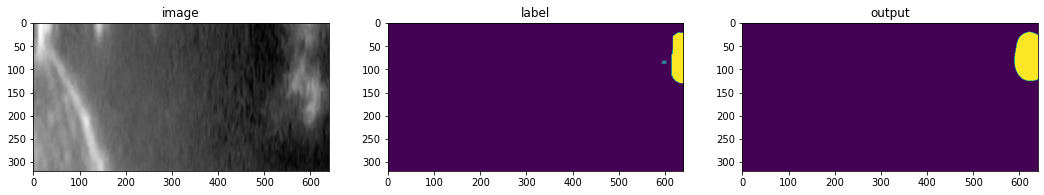

J = 1
Filename: 


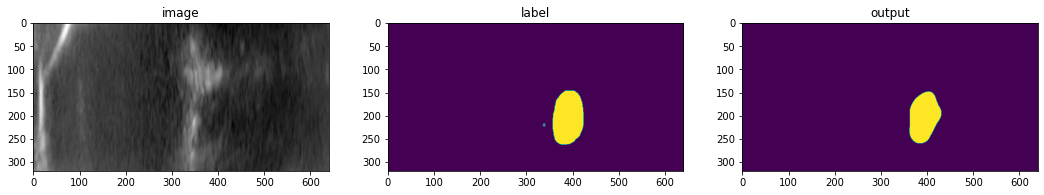

J = 2
Filename: 


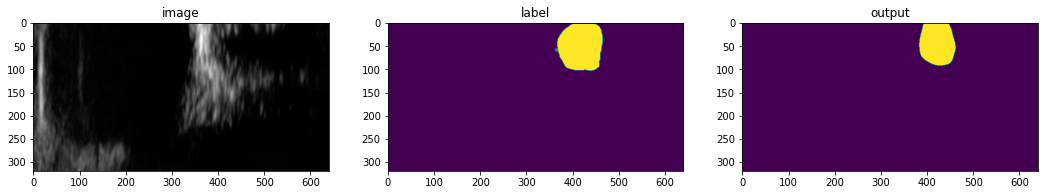

J = 3
Filename: 


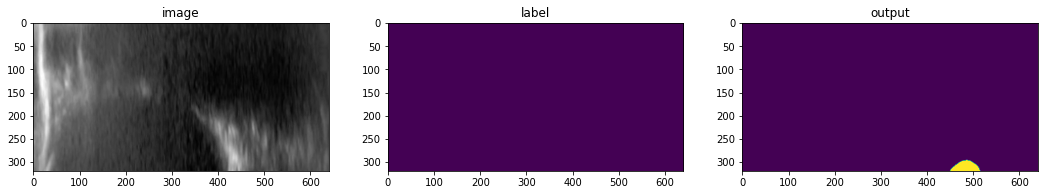

J = 4
Filename: 


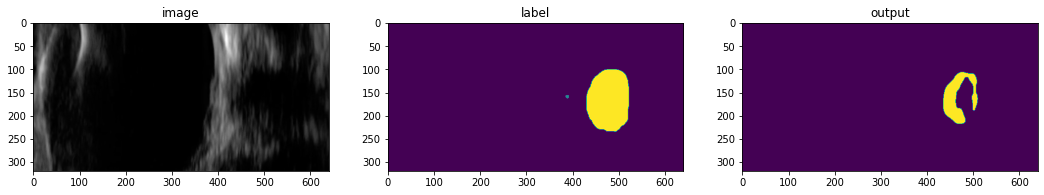

J = 5
Filename: 


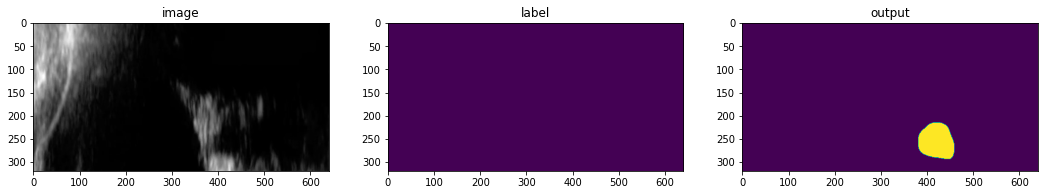

J = 6
Filename: 


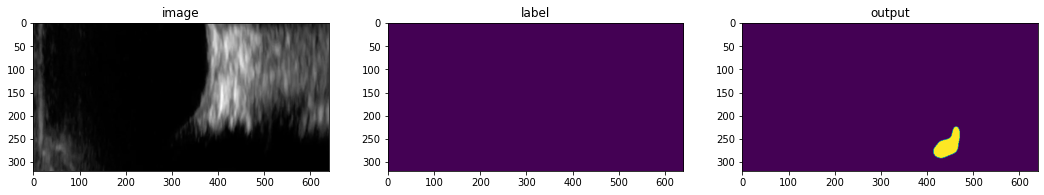

J = 7
Filename: 


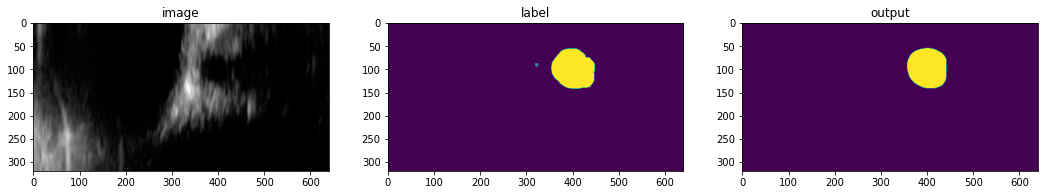

J = 8
Filename: 


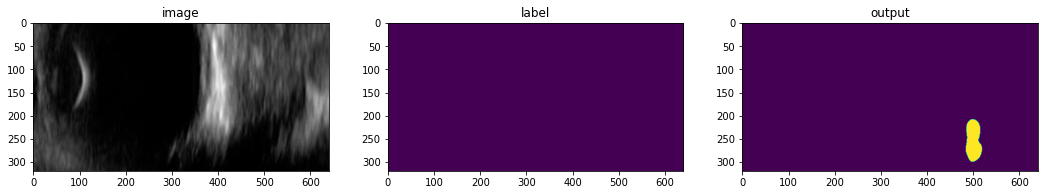

J = 9
Filename: 


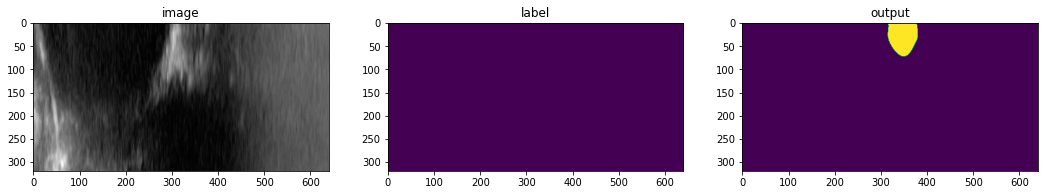

J = 10
Filename: 


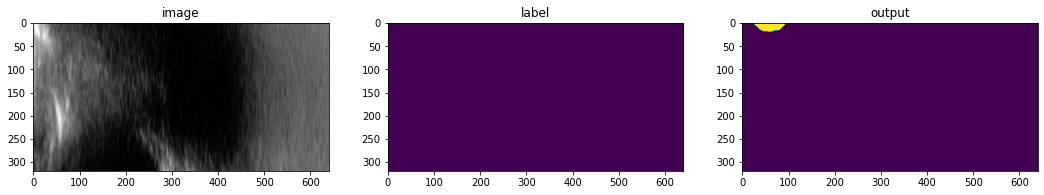

J = 11
Filename: 


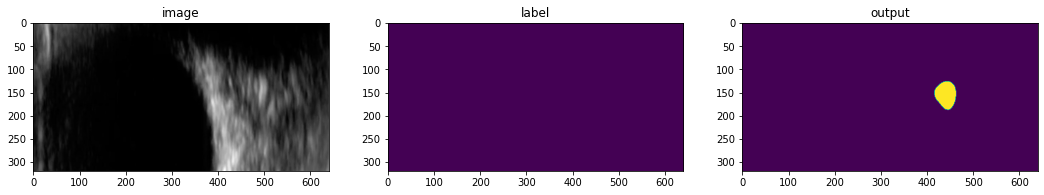

J = 12
Filename: 


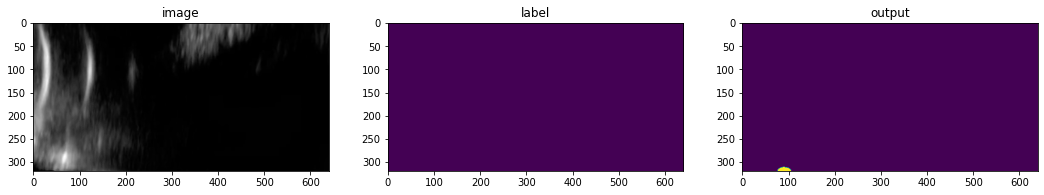

J = 13
Filename: 


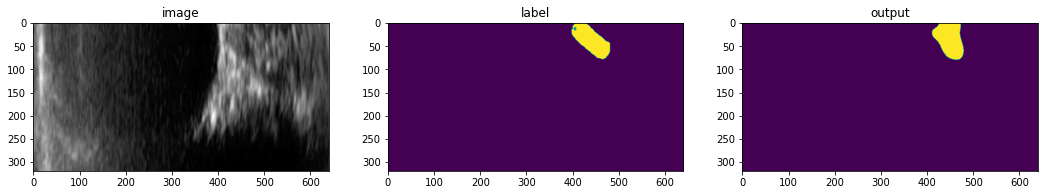

Loading dataset: 100%|██████████| 14/14 [00:15<00:00,  1.08s/it]

VFOLD = 5 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 5 = 0.6222032904624939
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 5 = 0.4425104260444641


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 5 = 0.49924924969673157
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 5 = 0.6159588694572449


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 5 = 0.44772329926490784
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 5 = 0.4361592233181
Output shape: (14, 3, 320, 640, 16)
Images shape: (14, 1, 320, 640, 16)
Labels shape: (14, 1, 320, 640, 16)
Test_op shape: (14, 2, 320, 640, 16)
../../Data_ONSD/Preprocessed/10. 250.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 119.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 158.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 228.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 64.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/3. 250.1 Right Lat_Video 2_cropM.mha
../../Data_ONSD/Preprocessed/4. 139.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 191.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 23.1 Right_Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/7. 108.1 Left_Lat_Video 1_cropM.mha
../../Data_ON

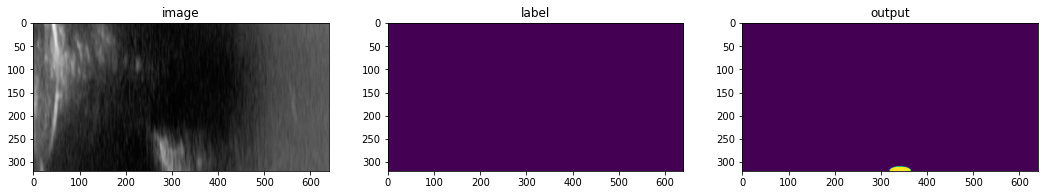

J = 1
Filename: 


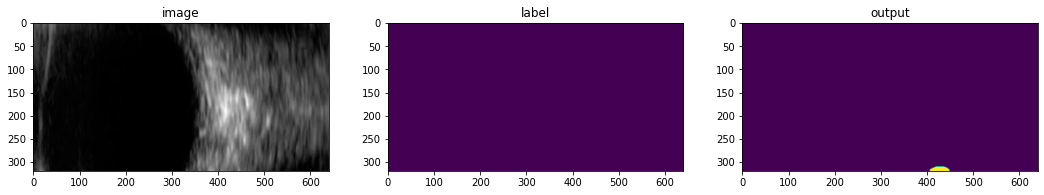

J = 2
Filename: 


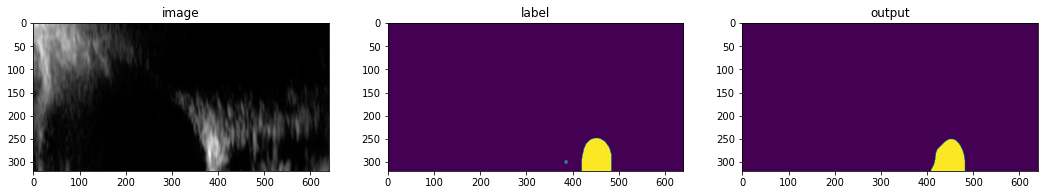

J = 3
Filename: 


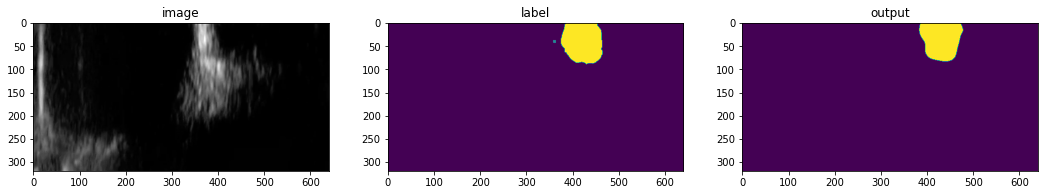

J = 4
Filename: 


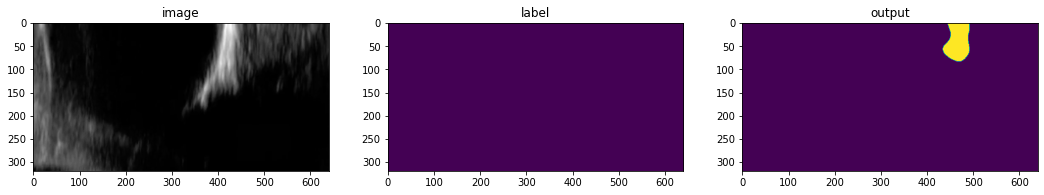

J = 5
Filename: 


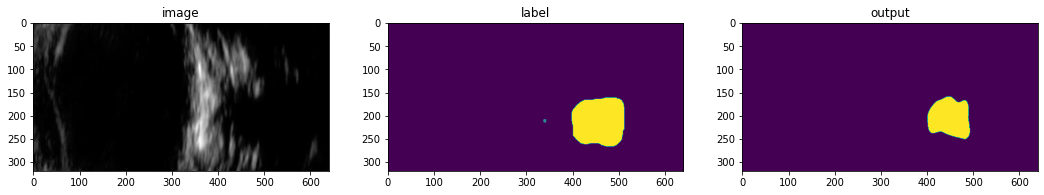

J = 6
Filename: 


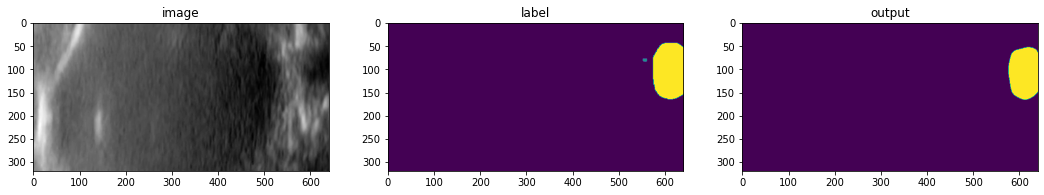

J = 7
Filename: 


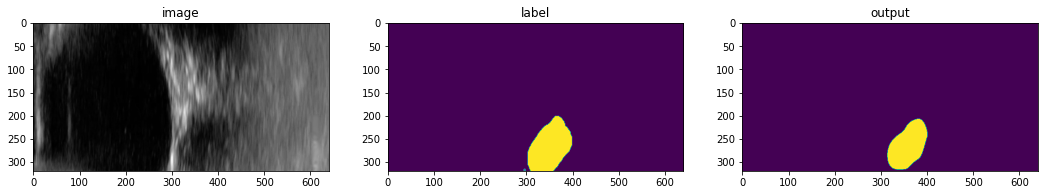

J = 8
Filename: 


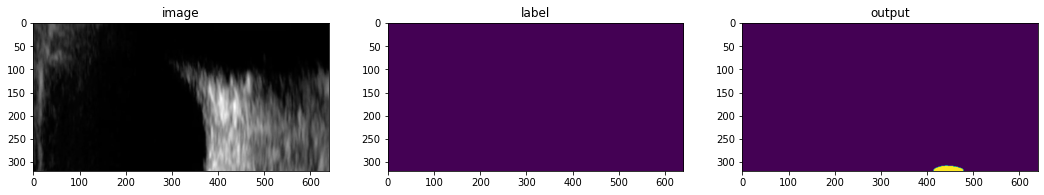

J = 9
Filename: 


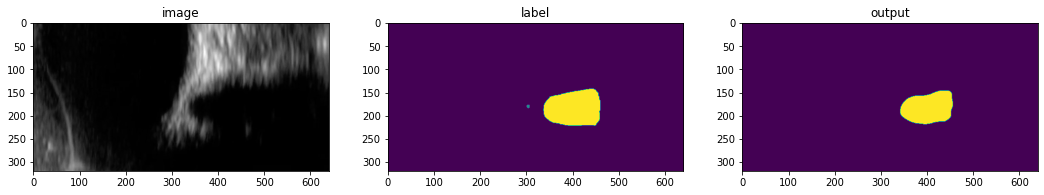

J = 10
Filename: 


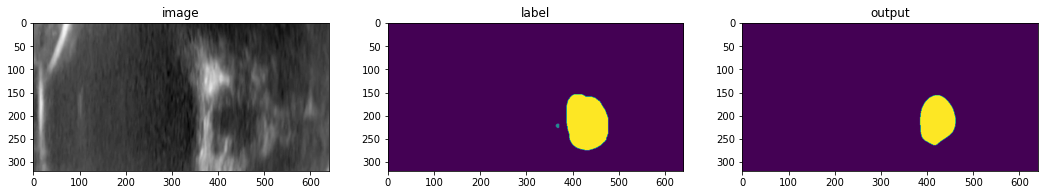

J = 11
Filename: 


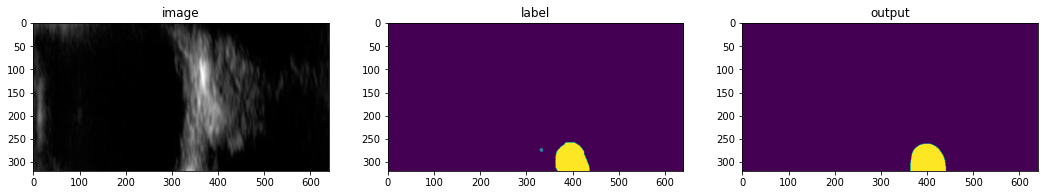

J = 12
Filename: 


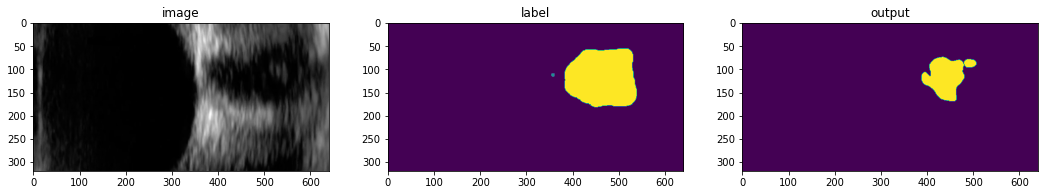

J = 13
Filename: 


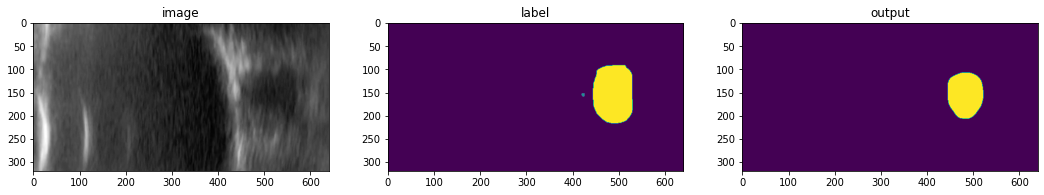

Loading dataset: 100%|██████████| 14/14 [00:15<00:00,  1.12s/it]

VFOLD = 6 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 6 = 0.32942909002304077
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 6 = 0.5008705258369446


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 6 = 0.4520920515060425
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 6 = 0.6076006889343262


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 6 = 0.5966922044754028
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 6 = 0.5337448120117188
Output shape: (14, 3, 320, 640, 16)
Images shape: (14, 1, 320, 640, 16)
Labels shape: (14, 1, 320, 640, 16)
Test_op shape: (14, 2, 320, 640, 16)
../../Data_ONSD/Preprocessed/10. 250.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 119.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 158.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 228.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 64.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/3. 250.1 Right Lat_Video 2_cropM.mha
../../Data_ONSD/Preprocessed/4. 139.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 23.1 Right_Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 87.2 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 129.1 Left_Lat_Video 1_cropM.mha
../../Data_O

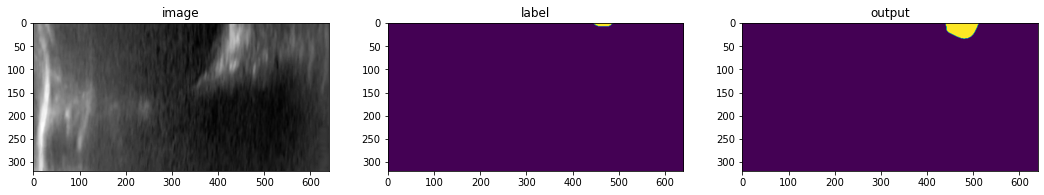

J = 1
Filename: 


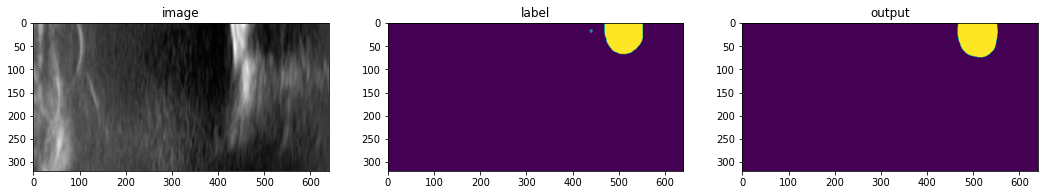

J = 2
Filename: 


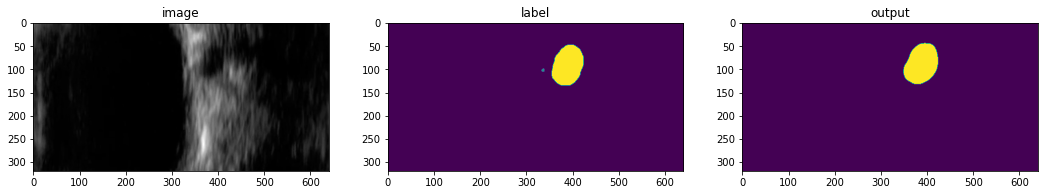

J = 3
Filename: 


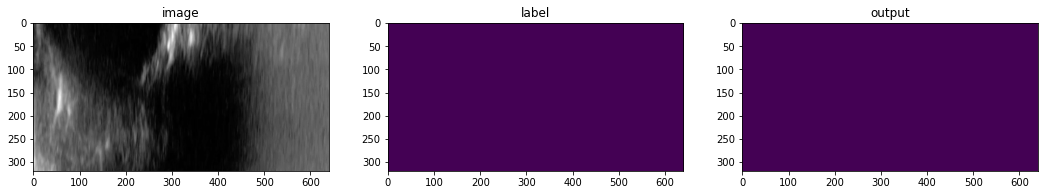

J = 4
Filename: 


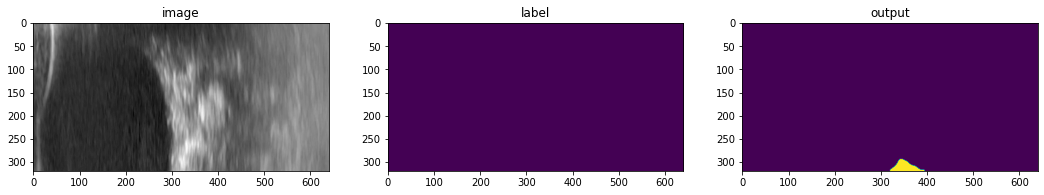

J = 5
Filename: 


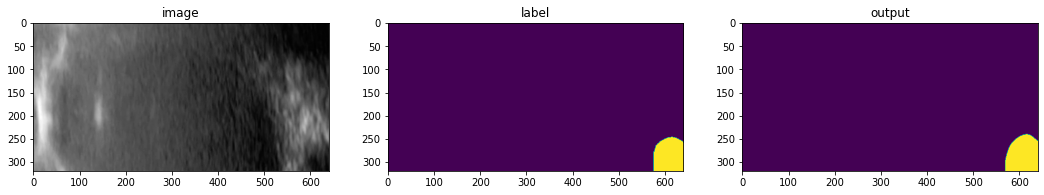

J = 6
Filename: 


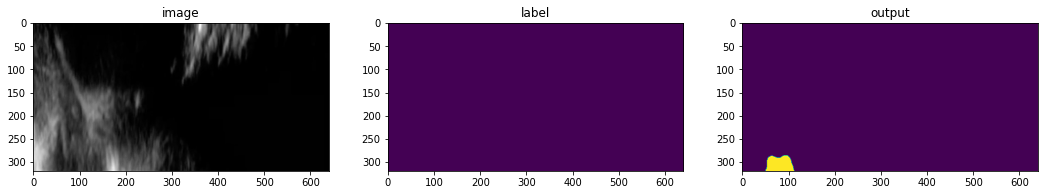

J = 7
Filename: 


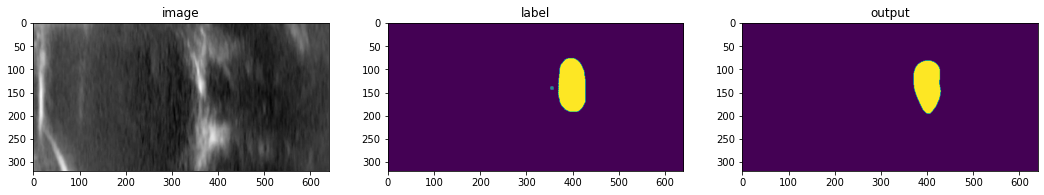

J = 8
Filename: 


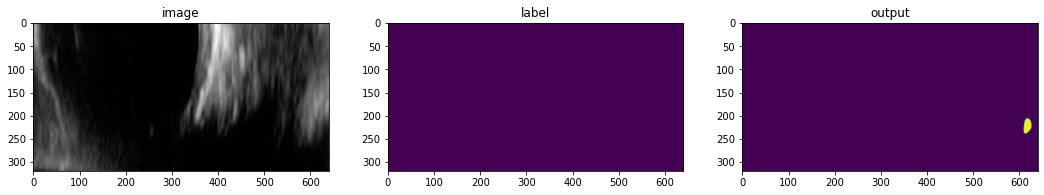

J = 9
Filename: 


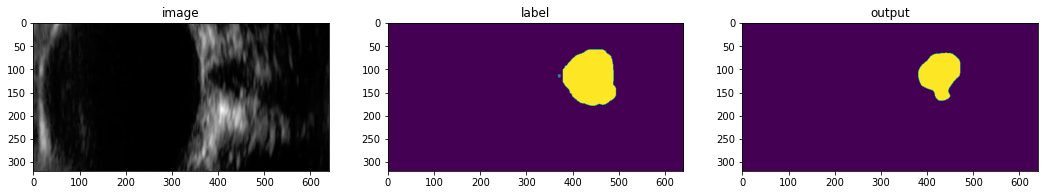

J = 10
Filename: 


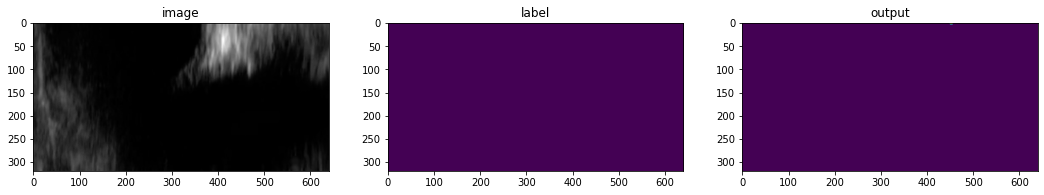

J = 11
Filename: 


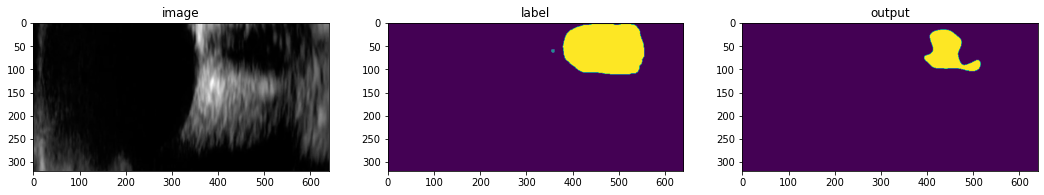

J = 12
Filename: 


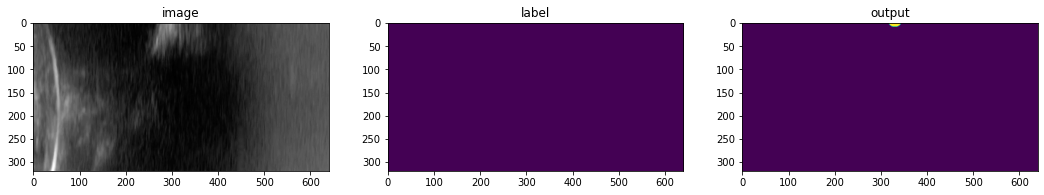

J = 13
Filename: 


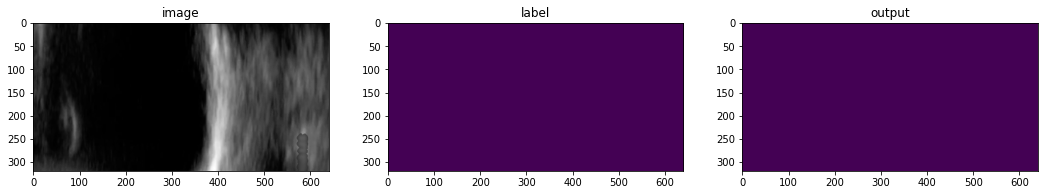

Loading dataset: 100%|██████████| 14/14 [00:15<00:00,  1.08s/it]

VFOLD = 7 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 7 = 0.3859878182411194
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 7 = 0.4474155008792877


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 7 = 0.4082571566104889
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 7 = 0.5876672863960266


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([8, 1, 320, 640, 16])
Average test dice score for Vfold 7 = 0.5597174167633057
1
torch.Size([6, 1, 320, 640, 16])
Average test dice score for Vfold 7 = 0.5570968985557556
Output shape: (14, 3, 320, 640, 16)
Images shape: (14, 1, 320, 640, 16)
Labels shape: (14, 1, 320, 640, 16)
Test_op shape: (14, 2, 320, 640, 16)
../../Data_ONSD/Preprocessed/10. 250.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 119.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 158.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 163.2 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/2. 64.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/3. 250.1 Right Lat_Video 2_cropM.mha
../../Data_ONSD/Preprocessed/4. 139.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 23.1 Right_Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 87.2 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 117.1 Left Lat_Video 1_cropM.mha
../../Data_O

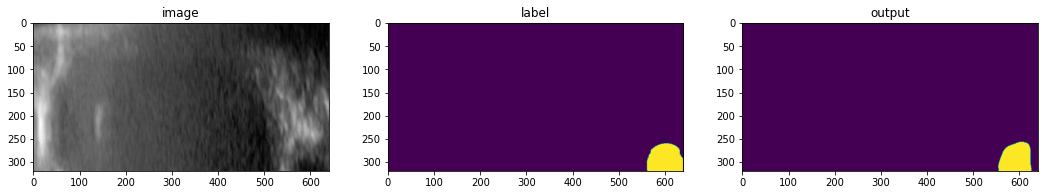

J = 1
Filename: 


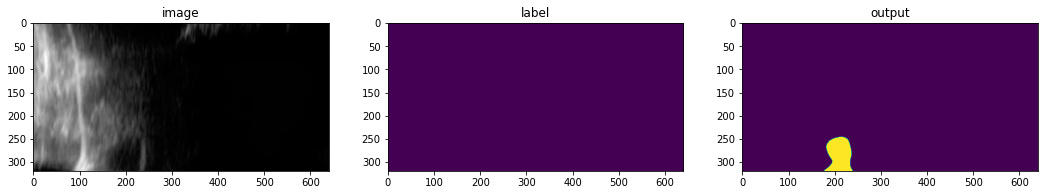

J = 2
Filename: 


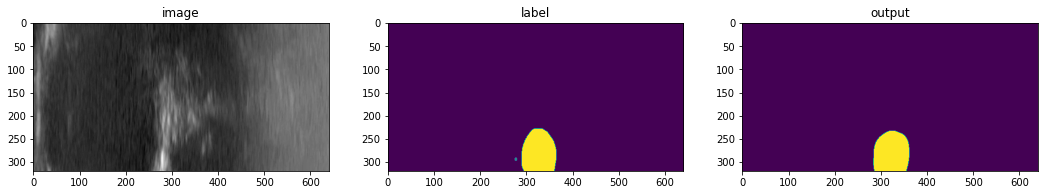

J = 3
Filename: 


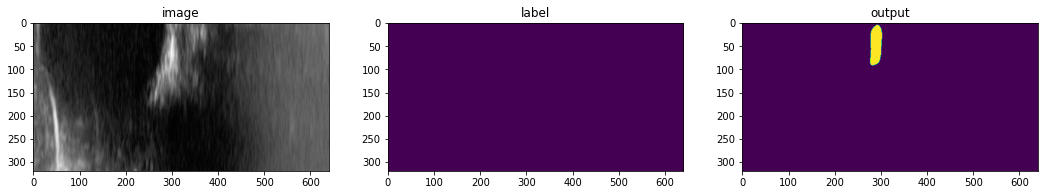

J = 4
Filename: 


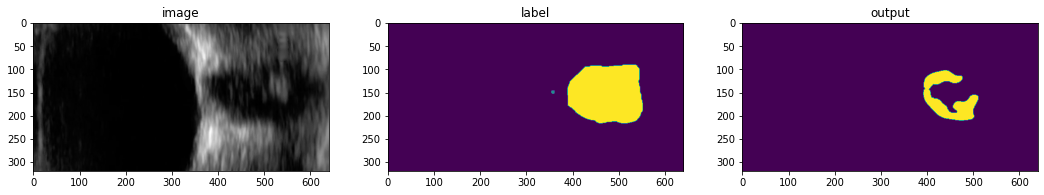

J = 5
Filename: 


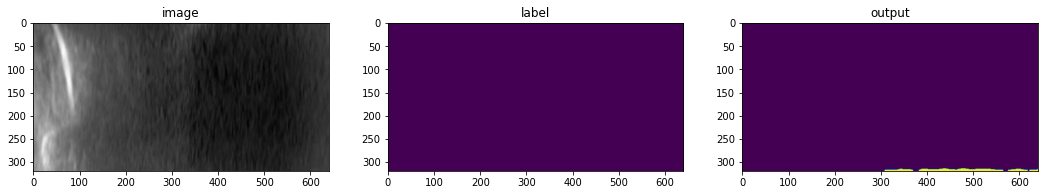

J = 6
Filename: 


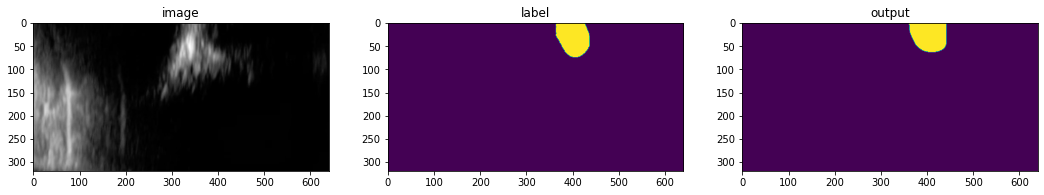

J = 7
Filename: 


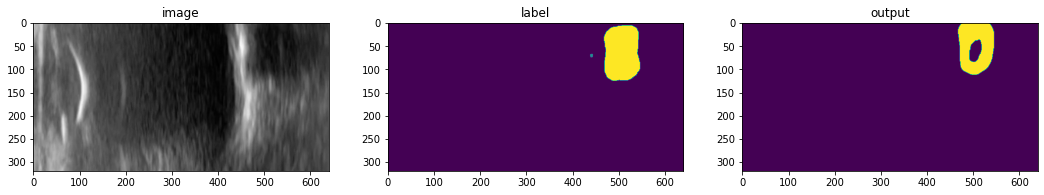

J = 8
Filename: 


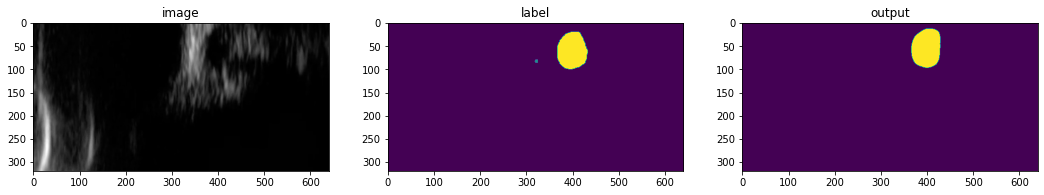

J = 9
Filename: 


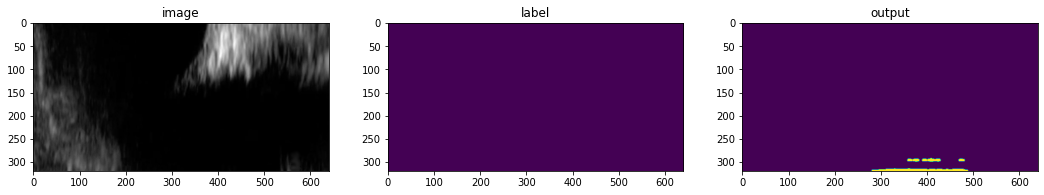

J = 10
Filename: 


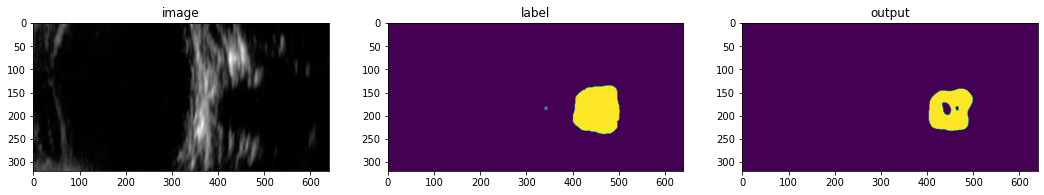

J = 11
Filename: 


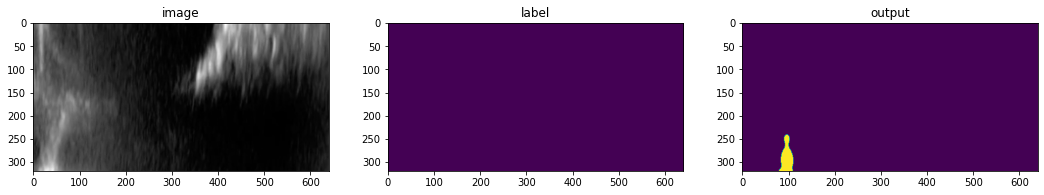

J = 12
Filename: 


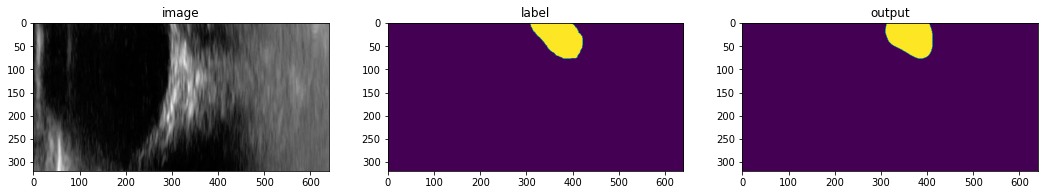

J = 13
Filename: 


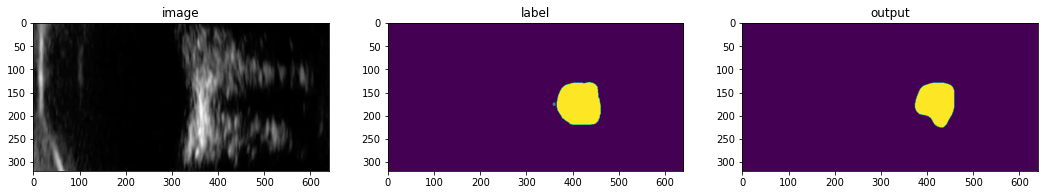

In [11]:
for i in range(0,num_folds,num_devices):
    train_ds = CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
    train_loader = DataLoader(train_ds, batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr)
    plot_vfold_training_curves(i,train_loader)
    train_loader.dataset._cache.clear()


In [12]:
import ipyparams
currentNotebook = "EnsembleClassPriorsTrain-CLEANED-3D_RawFrame-320x640-16s.ipynb"
exp = "EnsembleClassPriorsTrain-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s"

from datetime import datetime
now = datetime.now()
print(str(currentNotebook))
experimentName = exp+now.strftime("-%Y.%m.%d_%H.%M")
print(experimentName)
cmd = "jupyter nbconvert "+currentNotebook+" --output "+experimentName+" --to pdf"
import subprocess
subprocess.call(cmd, shell=True)

<IPython.core.display.Javascript object>

EnsembleClassPriorsTrain-CLEANED-3D_RawFrame-320x640-16s.ipynb
EnsembleClassPriorsTrain-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.02_15.31


[NbConvertApp] Converting notebook EnsembleClassPriorsTrain-CLEANED-3D_RawFrame-320x640-16s.ipynb to pdf
[NbConvertApp] Support files will be in EnsembleClassPriorsTrain-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.02_15.31_files/
[NbConvertApp] Making directory ./EnsembleClassPriorsTrain-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.02_15.31_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTrain-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.02_15.31_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTrain-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.02_15.31_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTrain-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.02_15.31_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTrain-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.02_15.31_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTrain-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue

0